## Mask R-CNN - Simulate the `DetectionTargetLayer` Process

We generate the inputs to `DetectTargetLayer` , to manipulate and modify the layer to procduce a modified `output_rois` 
containing false positives. 
This will be passed on the the heatmap layer, and through there will become the input to FCN.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')
import tensorflow as tf
import keras.backend as KB
import numpy as np
from mrcnn.datagen     import data_generator, load_image_gt
from mrcnn.callbacks   import get_layer_output_1,get_layer_output_2
from mrcnn.utils       import mask_string
import mrcnn.visualize as visualize
from mrcnn.prep_notebook import prep_dev_notebook

model, dataset_train, train_generator, config = prep_dev_notebook(init_with = 'init', FCN_layers = False)

D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Tensorflow Version: 1.6.0   Keras Version : 2.1.4 
 Initialize config object - super
(56, 56)
 COCO Model Path       :  E:\Models\mask_rcnn_coco.h5
 Checkpoint folder Path:  E:\Models\mrcnn_logs
E:\Models
E:\Models\mask_rcnn_coco.h5
E:\Models\resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
E:\Models\mrcnn_logs
>>> Initialize model WITHOUT MASKING LAYERS!!!!
    set_log_dir: Checkpoint path set to : E:\Models\mrcnn_logs\shapes20180516T1947\mask_rcnn_shapes_{epoch:04d}.h5
    set_log_dir: self.epoch set to 0 

>>> Resnet Graph 
     Input_image shape : (?, 128, 128, 3)
     After ZeroPadding2D  : (?, 134, 134, 3) (?, 134, 134, 3)
     After Conv2D padding : (?, 64, 64, 64) (?, 64, 64, 64)
     After BatchNorm      : (?, 64, 64, 64) (?, 64, 64, 64)
     After MaxPooling2D   : (?, 32, 32, 64) (?, 32, 32, 64)

>>> Feature Pyramid Network (FPN) Graph 
     FPN P2 shape : (None, 32, 32, 256)
     FPN P3 shape : (None, 16, 16, 256)
     FPN P4 shape : (None, 8, 8, 256)
     FPN P5 shape :

    gaussian_bbox_scores final shape   :  (?, ?, ?, ?)
    complete

 
  > NEW build_heatmap() for  ['gt_heatmap']
    orignal in_tensor shape :  (3, 4, 100, 6)
    num of bboxes per class is :  100
    pt2_sum shape  (3, 4, 100)
    dense shape  (?, 6)
    X/Y shapes : (128, 128) (128, 128)
    Ones:     (?, 1, 1)
    ones_exp * X (?, 1, 1) * (128, 128) =  (?, 128, 128)
    ones_exp * Y (?, 1, 1) * (128, 128) =  (?, 128, 128)
    before transpse  (?, 128, 128, 2)
    after transpose  (128, 128, ?, 2)
     Prob_grid shape before tanspose:  (128, 128, ?)
     Prob_grid shape after tanspose:  (?, 128, 128)
    >> input to MVN.PROB: pos_grid (meshgrid) shape:  (128, 128, ?, 2)
    << output probabilities shape: (?, 128, 128)

    Scatter out the probability distributions based on class --------------
    pt2_ind shape   :  (?, 3)
    prob_grid shape :  (?, 128, 128)
    gauss_scatt     :  (3, 4, 100, 128, 128)

    Reduce sum based on class ---------------------------------------------
  

### Get next shapes from generator and display loaded shapes

In [2]:
train_batch_x, train_batch_y = next(train_generator)


>>> Generate pyramid anchors 
      Anchor  scales:   (8, 16, 32, 64, 128)
      Anchor  ratios:   [0.5, 1, 2]
      Anchor  stride:   1
      Feature shapes:   [[32 32]
 [16 16]
 [ 8  8]
 [ 4  4]
 [ 2  2]]
      Feature strides:  [4, 8, 16, 32, 64]
>>> generate_anchors()
    scales:  8 ratios:  [0.5, 1, 2]
    meshgrid scales:  (3, 1) ratios:  (3, 1)
    flattened meshgrid scales and ratios:  (3,) (3,)
    Heights  [11.3137  8.      5.6569]  widths   [ 5.6569  8.     11.3137]
>>> generate_anchors()
    scales:  16 ratios:  [0.5, 1, 2]
    meshgrid scales:  (3, 1) ratios:  (3, 1)
    flattened meshgrid scales and ratios:  (3,) (3,)
    Heights  [22.6274 16.     11.3137]  widths   [11.3137 16.     22.6274]
>>> generate_anchors()
    scales:  32 ratios:  [0.5, 1, 2]
    meshgrid scales:  (3, 1) ratios:  (3, 1)
    flattened meshgrid scales and ratios:  (3,) (3,)
    Heights  [45.2548 32.     22.6274]  widths   [22.6274 32.     45.2548]
>>> generate_anchors()
    scales:  64 ratios:  [0.

Image id:  36
Image meta [ 36 128 128   3   0   0 128 128   1   1   1   1]
Classes (1: circle, 2: square, 3: triangle ):  [2 3]


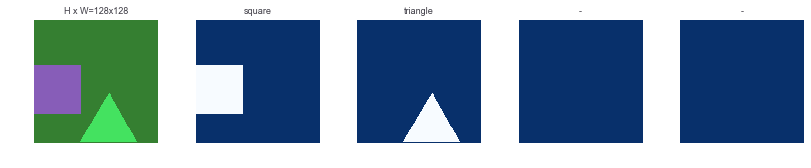

Image id:  135
Image meta [135 128 128   3   0   0 128 128   1   1   1   1]
Classes (1: circle, 2: square, 3: triangle ):  [2]


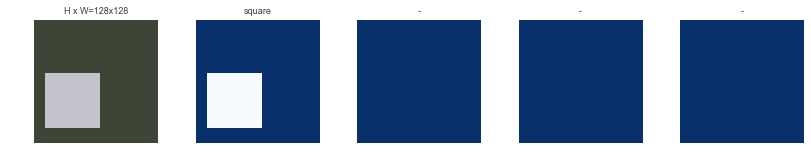

Image id:  116
Image meta [116 128 128   3   0   0 128 128   1   1   1   1]
Classes (1: circle, 2: square, 3: triangle ):  [3 1 2]


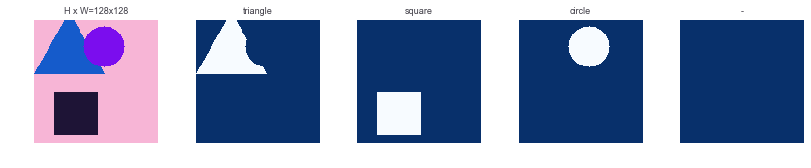

In [3]:
### Display loaded shapes

# train_batch_x, train_batch_y = next(train_generator)
imgmeta_idx = model.keras_model.input_names.index('input_image_meta')
img_meta    = train_batch_x[imgmeta_idx]

for img_idx in range(config.BATCH_SIZE):
    image_id = img_meta[img_idx,0]
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    print('Image id: ',image_id)
    print('Image meta', img_meta[img_idx])
    print('Classes (1: circle, 2: square, 3: triangle ): ',class_ids)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

###  Print some model information 

In [4]:
model.layer_info()



 Inputs:
 -------
 layer:  0    output : input_image:0                              Type: float32           Shape: (?, 128, 128, 3)
 layer:  1    output : input_image_meta:0                         Type: float32           Shape: (?, ?)
 layer:  2    output : input_rpn_match:0                          Type: int32             Shape: (?, ?, 1)
 layer:  3    output : input_rpn_bbox:0                           Type: float32           Shape: (?, ?, 4)
 layer:  4    output : input_gt_class_ids:0                       Type: int32             Shape: (?, ?)
 layer:  5    output : input_gt_boxes:0                           Type: float32           Shape: (?, ?, 4)
 layer:  6    output : input_gt_masks:0                           Type: bool              Shape: (?, 56, 56, ?)


 Outputs:
 --------
 layer:  0    output : rpn_class_logits/concat:0                  Type: float32           Shape: (?, ?, 2)
 layer:  1    output : rpn_class/concat:0                         Type: float32           Shape:

### Push Data thru model using get_layer_output()

In [5]:

# model_output = get_layer_output_2(model.keras_model, train_batch_x, 1)

model_output = get_layer_output_1(model.keras_model, train_batch_x, [3,4, 17,19], verbose = True)


/* Inputs */
Input  0:  (input_image:0                           ) 	  Input shape: (3, 128, 128, 3)
Input  1:  (input_image_meta:0                      ) 	  Input shape: (3, 12)
Input  2:  (input_rpn_match:0                       ) 	  Input shape: (3, 4092, 1)
Input  3:  (input_rpn_bbox:0                        ) 	  Input shape: (3, 256, 4)
Input  4:  (input_gt_class_ids:0                    ) 	  Input shape: (3, 100)
Input  5:  (input_gt_boxes:0                        ) 	  Input shape: (3, 100, 4)
Input  6:  (input_gt_masks:0                        ) 	  Input shape: (3, 56, 56, 100)

/* Outputs */
Output idx:  0    Layer:  3: (rpn_proposal_rois/packed_2:0            ) 	  Output shape: (3, 2000, 4)
Output idx:  1    Layer:  4: (proposal_targets/output_rois:0          ) 	  Output shape: (3, 32, 4)
Output idx:  2    Layer: 17: (cntxt_layer/pred_heatmap_scores:0       ) 	  Output shape: (3, 4, 32, 8)
Output idx:  3    Layer: 19: (cntxt_layer/pred_tensor:0               ) 	  Output shape: 

In [7]:
# del input_image, input_image_meta, input_gt_class_ids, input_gt_bboxes #, input_gt_bboxes_norm
input_image      =  train_batch_x[0]
input_image_meta =  train_batch_x[1]
# input_rpn_match  =  train_batch_x[2]
# input_rpn_bbox   =  train_batch_x[3]
input_gt_class_ids = train_batch_x[4]
input_gt_bboxes    = train_batch_x[5]
# input_gt_masks     = train_batch_x[6]
print(input_image.shape)
h, w = input_image.shape[1], input_image.shape[2]      #  tf.shape(input_image)[1], tf.shape(input_image)[2]
print('height/width', h,w)
input_gt_bboxes_norm = input_gt_bboxes / [h,w,h,w]

# gt_masks   =  train_batch_x[6]
# print(' input_rpn_match    ', input_rpn_match.shape)
# print(' input_rpn_bbox     ', input_rpn_bbox.shape)
print(' input_gt_class_ids   ', input_gt_class_ids.shape)
print(input_gt_class_ids)
print(' input_gt_bboxes      ', input_gt_bboxes.shape)
print(input_gt_bboxes)  
print(' input_gt_bboxes_norm ', input_gt_bboxes_norm.shape)
print( input_gt_bboxes_norm)

(3, 128, 128, 3)
height/width 128 128
 input_gt_class_ids    (3, 100)
[[2 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0]
 [2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0]
 [3 1 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0]]
 input_gt_bboxes       (3, 100, 4)
[[[ 47   0  98  49]
  [ 76  48 127 106]
  [  0   0   0   0]
  ...
  [  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]]

 [[ 56  11 113  68]
  [  0   0   0   0]
  [  0   0   0   0]
  ...
  [  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]]

 [[  0   0  57  7

In [8]:
print(len(model_output))
# rpn_class_logits   = model_output[0]
# rpn_class          = model_output[0]
# rpn_bbox           = model_output[1]
rpn_proposal_rois  = model_output[0]
output_rois        = model_output[1]
# target_class_ids   = model_output[5]
# target_bbox_deltas = model_output[6]
# roi_gt_boxes       = model_output[7]
# mrcnn_class_logits = model_output[8]
# mrcnn_class        = model_output[0]
# mrcnn_bbox         = model_output[10]
# rpn_class_loss   = model_output[11]
# rpn_bbox_loss    = model_output[12]
# mrcnn_class_loss = model_output[13]
# mrcnn_bbox_loss  = model_output[14]
# fcn_bbox_loss      = model_output[15]
# pred_hm            = model_output[1]
# gt_hm              = model_output[17]
# pred_hm_norm       = model_output[1]
# gt_hm_norm         = model_output[2]
# pred_hm_scores     = model_output[3]
# gt_hm_scores       = model_output[4]
# pred_tensor        = model_output[5]
# fcn_heatmap        = model_output[23]
# fcn_class_logits   = model_output[24]
# fcn_scores         = model_output[25]
# fcn_bbox_deltas    = model_output[26]
# pred_hm2            = model_output[2]
# pred_hm2_norm       = model_output[3]
# rpn_proposal_rois  = model_output[0]
# output_rois        = model_output[1]
# pred_hm_norm       = model_output[1]
# gt_hm_norm         = model_output[3]
pred_hm_scores     = model_output[2]
# gt_hm_scores       = model_output[5]
pred_tensor        = model_output[3]

# print(type(model_output[4]))
# print(type(output_rois))
for i in model_output:
    print( i.shape)

4
(3, 2000, 4)
(3, 32, 4)
(3, 4, 32, 8)
(3, 4, 32, 6)


In [9]:
print(rpn_proposal_rois[0])
# print(output_rois[0])
# print(pred_tensor[0])

[[0.7732 0.225  1.     0.6652]
 [0.7909 0.3989 1.     0.8573]
 [0.     0.     1.     1.    ]
 ...
 [0.1877 0.0054 0.2105 0.2402]
 [0.5644 0.     0.5847 1.    ]
 [0.0453 0.4127 0.11   0.6564]]


In [ ]:
print(input_gt_boxes.shape, input_image.shape)
print(rpn_proposal_rois.shape)
print((rpn_proposal_rois[0,:5,:]*[128,128,128,128]))

###  Setup tensors to be passed to `detections_target_graph()`

This is passed to the DetectionTargetLayer


In [31]:
import mrcnn.utils  as utils
from mrcnn.detect_tgt_layer import overlaps_graph
# sess = KB.get_session()
# with  sess.as_default():
try:
    sess.close()
    print('session was deleted ')
except:
    print('Session was not defined ')
    pass
sess = tf.InteractiveSession()

image_id = 2

proposals    = KB.identity(rpn_proposal_rois)[image_id]
gt_class_ids = KB.identity(input_gt_class_ids)[image_id]
gt_boxes     = KB.cast(KB.identity(input_gt_bboxes_norm), dtype='float32')[image_id]
# gt_masks     = KB.identity(input_gt_masks)
print(proposals.dtype, gt_class_ids.dtype, gt_boxes.dtype)
print(proposals.shape)
print(proposals.eval())
print(gt_class_ids.shape)
print(gt_class_ids.eval())
print(gt_boxes.shape)
print(gt_boxes.eval())
# proposals    = rpn_proposal_rois[1]
# gt_class_ids = input_gt_class_ids[1]
# gt_boxes     = input_normlzd_gt_boxes[1]
# gt_masks     = input_gt_masks[1]
# config       = model.config

session was deleted 
<dtype: 'float32'> <dtype: 'int32'> <dtype: 'float32'>
(2000, 4)
[[0.     0.     0.0482 0.44  ]
 [0.0145 0.     0.017  0.1724]
 [0.1483 0.138  0.1715 0.2534]
 ...
 [0.174  0.5101 0.1922 0.5183]
 [0.     0.2143 1.     0.2311]
 [0.8634 0.8752 0.9407 0.907 ]]
(100,)
[3 1 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
(100, 4)
[[0.     0.     0.4453 0.5703]
 [0.0547 0.3984 0.3906 0.7344]
 [0.5859 0.1641 0.9375 0.5156]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.  

### def `dev_detection_targets_graph`

In [41]:
# def dev_detection_targets_graph(proposals, gt_class_ids, gt_boxes, gt_masks, config):
 
'''
as of 16-0-2018
Generates detection targets for one image. Subsamples proposals and
generates target class IDs, bounding box deltas, and masks for each.

Inputs:
-------
proposals:          [N, 2000, (y1, x1, y2, x2)] in normalized coordinates. 
                         Might be zero padded if there are not enough proposals.
gt_class_ids:       [MAX_GT_INSTANCES] int class IDsMx2)] in normalized coordinates.
gt_masks:           [height, width, MAX_GT_INSTANCES] of boolean type.

Returns:            Target ROIs and corresponding class IDs, bounding box shifts, and masks.
--------
rois:               [TRAIN_ROIS_PER_IMAGE, (y1, x1, y2, x2)] in normalized coordinates
class_ids:          [TRAIN_ROIS_PER_IMAGE]. Integer class IDs. Zero padded.
deltas:             [TRAIN_ROIS_PER_IMAGE, NUM_CLASSES, (dy, dx, log(dh), log(dw))]
                    Class-specific bbox refinments.
masks:              [TRAIN_ROIS_PER_IMAGE, height, width). Masks cropped to bbox
                    boundaries and resized to neural network output size.

Note: Returned arrays might be zero padded if not enough target ROIs.

''' 
# Assertions
asserts = [
    tf.Assert(tf.greater(tf.shape(proposals)[0], 0), [proposals], name="roi_assertion"),
]

with tf.control_dependencies(asserts):
    proposals = tf.identity(proposals)
# print('>>> detection_targets_graph ')
# print('     propsals.shape        :',  proposals.shape, proposals.get_shape(), KB.int_shape(proposals) )
# print('     gt_boxes.shape        :',  gt_boxes.shape ,    KB.int_shape(gt_boxes)   )
# print('     gt_class_ids.shape    :',  gt_class_ids.shape, KB.int_shape(gt_class_ids))
# print('     gt_masks.shape        :',  gt_masks.shape ,    KB.int_shape(gt_masks)   )

# Remove zero padding   
# non_zeros returns indicies to valid bboxes, which we use to index gt_class_ids, and gt_masks
proposals, non_zeros1= utils.trim_zeros_graph(proposals, name="trim_proposals")
gt_boxes, non_zeros = utils.trim_zeros_graph(gt_boxes , name="trim_gt_boxes")
gt_class_ids        = tf.boolean_mask(gt_class_ids, non_zeros, name="trim_gt_class_ids")
# gt_masks            = tf.gather(gt_masks, tf.where(non_zeros)[:, 0], axis=2,name="trim_gt_masks")

print(tf.reduce_all(non_zeros1).eval())
print(tf.shape(proposals).eval())
print(non_zeros.eval())
print(tf.shape(gt_boxes).eval())
print(gt_boxes.eval())

#------------------------------------------------------------------------------------------
# Handle COCO crowds
# A crowd box in COCO is a bounding box around several instances. Exclude
# them from training. A crowd box is given a negative class ID.
#------------------------------------------------------------------------------------------
# tf.where : returns the coordinates of true elements of  the specified conditon.
#            The coordinates are returned in a 2-D tensor where the first dimension (rows) 
#            represents the number of true elements, and the second dimension (columns) 
#            represents the coordinates of the true elements. 
#            Keep in mind, the shape of the output tensor can vary depending on how many 
#            true values there are in input. Indices are output in row-major order.
#
# tf.gather: Gather slices from params axis (default = 0) according to indices.
#            indices must be an integer tensor of any dimension (usually 0-D or 1-D). 
#            Produces an output tensor with shape:
#                   params.shape[:axis] + indices.shape + params.shape[axis + 1:] 
#
# tf.squeeze: Removes dimensions of size 1 from the shape of a tensor.
#            Given a tensor input, this operation returns a tensor of the same type with 
#            all dimensions of size 1 removed. If you don't want to remove all size 1 
#            dimensions, you can remove specific size 1 dimensions by specifying axis.
#------------------------------------------------------------------------------------------

crowd_ix        = tf.where(gt_class_ids < 0)[:, 0]
non_crowd_ix    = tf.where(gt_class_ids > 0)[:, 0]
crowd_boxes     = tf.gather(gt_boxes, crowd_ix)
# crowd_masks     = tf.gather(gt_masks, crowd_ix, axis=2)
gt_class_ids    = tf.gather(gt_class_ids, non_crowd_ix)
gt_boxes        = tf.gather(gt_boxes, non_crowd_ix)
# gt_masks        = tf.gather(gt_masks, non_crowd_ix, axis=2)
print(non_crowd_ix.eval())
print(gt_boxes.eval())

# Compute overlaps with crowd boxes [anchors, crowds]
crowd_overlaps  = overlaps_graph(proposals, crowd_boxes)
crowd_iou_max   = tf.reduce_max(crowd_overlaps, axis=1)
no_crowd_bool   = (crowd_iou_max < 0.001)

# Compute overlaps matrix [proposals, gt_boxes] - The IoU between 
# proposals and gt_boxes (non-crowd gt boxes, designated by classId < 0 in Coco)
# overlaps is 
# compute max of elements across axis 1 of overlaps tensor. 
overlaps        = overlaps_graph(proposals, gt_boxes)
roi_iou_max     = tf.reduce_max(overlaps, axis=1)
print('     overlaps.shape        :',  tf.shape(overlaps).eval())
print(overlaps.eval())
zero_idxs = tf.where(tf.greater_equal(overlaps,0.5))
print(tf.shape(zero_idxs).eval())

## 1. Determine indices of postive ROI propsal boxes
#    Identify ROI proposal boxes that have an IoU >= 05 overlap with some gt_box, and store 
#    indices into positive_indices
positive_roi_bool     = (roi_iou_max >= 0.5)
positive_indices      = tf.where(positive_roi_bool)[:,0]
print(tf.shape(positive_roi_bool).eval())
print(tf.shape(positive_indices).eval())
print(positive_indices.eval())



## 2. Determine indices of negative ROI proposal boxes
#    those with < 0.5 with every GT box and are not crowds bboxes 
# the where creates a array with shape [# of answers, 1] so we use [:, 0] after
## current method
negative_indices      = tf.where(tf.logical_and(roi_iou_max < 0.5, no_crowd_bool))[:, 0]

## new method
# this modification will determine negative ROI proposal boxes but in addition, 
# will suppress the zero RoIs from the indicies 
# note that   ( negative_bool         = ~positive_roi_bool)
# negative_nonzero_bool = tf.logical_and(~positive_roi_bool, (roi_iou_max > 0))
# negative_nonzero_bool = tf.logical_and(negative_nonzero_bool, no_crowd_bool)
# negative_indices2     = tf.where(negative_nonzero_bool) [:, 0]

## 3. Subsample positive ROIs based on ROI_POSITIVE_RATIO
#    Aim for 33% positive (config.ROI_POSITIVE_RATIO = 0.33)
#    Positive ROIs   33% of config.TRAIN_ROIS_PER_IMAGE ~  11
positive_count        = int(config.TRAIN_ROIS_PER_IMAGE * config.ROI_POSITIVE_RATIO)
positive_indices      = tf.random_shuffle(positive_indices)[:positive_count]
positive_count        = tf.shape(positive_indices)[0]

print(positive_indices.eval())
print(positive_count.eval())

## 4. Add Negative ROIs. Add enough to maintain positive:negative ratio
#     negative_count = int((positive_count / config.ROI_POSITIVE_RATIO) - positive_count)
r = 1.0 / config.ROI_POSITIVE_RATIO
negative_count        = tf.cast(r * tf.cast(positive_count, tf.float32), tf.int32) - positive_count
negative_indices      = tf.random_shuffle(negative_indices)[:negative_count]

## 5.   Gather selected positive and negative ROIs
positive_rois         = tf.gather(proposals, positive_indices)
negative_rois         = tf.gather(proposals, negative_indices)
print(positive_rois.eval())

## 6.   Assign positive ROIs to GT boxes.
#      roi_gt_box_assignment shows for each positive overlap, which class has the maximum overlap
positive_overlaps     = tf.gather(overlaps, positive_indices)
roi_gt_box_assignment = tf.argmax(positive_overlaps, axis=1)
roi_gt_boxes          = tf.gather(gt_boxes    , roi_gt_box_assignment)
roi_gt_class_ids      = tf.gather(gt_class_ids, roi_gt_box_assignment)

print('     shape of positive overlaps is :', positive_overlaps.get_shape())
print(roi_gt_box_assignment.eval())
print(positive_overlaps.eval())

## 7.   Compute bbox delta 
# calculate refinement (difference b/w positive rois and gt_boxes) for positive ROIs
roi_gt_deltas  = utils.box_refinement_graph(positive_rois, roi_gt_boxes)
roi_gt_deltas /= config.BBOX_STD_DEV

## 8.  prepare gt_masks 
#      transpose gt_masks from [h, w, N] to [N, height, width] and add 4th dim at end [N, height, width, 1]
#      Pick the right mask for each ROI
# transposed_masks = tf.expand_dims(tf.transpose(gt_masks, [2, 0, 1]), -1)
# roi_masks = tf.gather(transposed_masks, roi_gt_box_assignment)

# Compute mask targets
# boxes = positive_rois

# if config.USE_MINI_MASK:
    # Transform ROI corrdinates from normalized image space
    # to normalized mini-mask space.
    # y1, x1, y2, x2 = tf.split(positive_rois, 4, axis=1)
    # gt_y1, gt_x1, gt_y2, gt_x2 = tf.split(roi_gt_boxes, 4, axis=1)
    # gt_h = gt_y2 - gt_y1
    # gt_w = gt_x2 - gt_x1
    # y1 = (y1 - gt_y1) / gt_h
    # x1 = (x1 - gt_x1) / gt_w
    # y2 = (y2 - gt_y1) / gt_h
    # x2 = (x2 - gt_x1) / gt_w
    # boxes = tf.concat([y1, x1, y2, x2], 1)

# box_ids = tf.range(0, tf.shape(roi_masks)[0])
# masks   = tf.image.crop_and_resize(tf.cast(roi_masks, tf.float32), 
                                   # boxes,
                                   # box_ids,
                                   # config.MASK_SHAPE)

# Remove the extra dimension from masks.
# masks = tf.squeeze(masks, axis=3)

# Threshold mask pixels at 0.5 to have GT masks be 0 or 1 to use with
# binary cross entropy loss.
# masks = tf.round(masks)

# Append negative ROIs and pad bbox roi_gt_deltas and masks that
# are not used for negative ROIs with zeros.
rois             = tf.concat([positive_rois, negative_rois], axis=0)
N                = tf.shape(negative_rois)[0]
P                = tf.maximum(config.TRAIN_ROIS_PER_IMAGE - tf.shape(rois)[0], 0)
rois             = tf.pad(rois            , [(0, P ), (0, 0)])

roi_gt_boxes     = tf.pad(roi_gt_boxes    , [(0, N + P), (0, 0)])
roi_gt_class_ids = tf.pad(roi_gt_class_ids, [(0, N + P)])
roi_gt_deltas    = tf.pad(roi_gt_deltas   , [(0, N + P), (0, 0)])
# masks            = tf.pad(masks           , [[0, N + P], (0, 0), (0, 0)])

# print(' roi_gt_boxes :  ' , tf.shape(roi_gt_boxes) )
# print(' P:  ' , P,  ' N :    ', N)   
# print('     roi.shape             :',  rois.shape            , tf.shape(rois))
# print('     roi_gt_class_ids.shape:',  roi_gt_class_ids.shape, tf.shape(roi_gt_class_ids))
# print('     roi_gt_deltas.shape   :',  roi_gt_deltas.shape   , tf.shape(roi_gt_deltas))
# print('     masks.shape           :',  masks.shape           , tf.shape(masks))
# print('     roi_gt_boxes.shape    :',  roi_gt_boxes.shape    , tf.shape(roi_gt_boxes))

#     return rois, roi_gt_class_ids,  roi_gt_deltas, roi_gt_boxes
#     return positive_ind_shuffled, positive_indices, positive_overlaps, roi_gt_box_assignment, roi_gt_boxes, roi_gt_class_ids

True
[2000    4]
[ True  True  True]
[3 4]
[[0.     0.     0.4453 0.5703]
 [0.0547 0.3984 0.3906 0.7344]
 [0.5859 0.1641 0.9375 0.5156]]
[0 1 2]
[[0.     0.     0.4453 0.5703]
 [0.0547 0.3984 0.3906 0.7344]
 [0.5859 0.1641 0.9375 0.5156]]
     overlaps.shape        : [2000    3]
[[0.0836 0.     0.    ]
 [0.0017 0.     0.    ]
 [0.0105 0.     0.    ]
 ...
 [0.0006 0.0013 0.    ]
 [0.0285 0.     0.044 ]
 [0.     0.     0.    ]]
[8 2]
[2000]
[8]
[ 257  365  420  432  661  798  991 1264]
[1264  432  661  991  420  798  257  365]
8
[[0.5462 0.26   1.     0.5613]
 [0.     0.     0.3301 0.7111]
 [0.     0.     0.4078 0.4211]
 [0.     0.     0.675  0.5631]
 [0.6335 0.0174 0.8874 0.4826]
 [0.5844 0.     1.     0.5543]
 [0.     0.009  0.6593 0.411 ]
 [0.     0.14   0.3856 0.6639]]
     shape of positive overlaps is : (?, ?)
[0 0 2 0 2 0 2 0]
[[0.     0.     0.5028]
 [0.6266 0.3293 0.    ]
 [0.     0.     0.5365]
 [0.5266 0.0113 0.0489]
 [0.6542 0.1264 0.0663]
 [0.     0.     0.5272]
 [0.6762 0.0

In [42]:
print(tf.shape(rois).eval())
print(rois.eval())
print(roi_gt_class_ids.eval())
print(gt_class_ids.eval())
print(gt_boxes.eval())

[32  4]
[[0.     0.009  0.6593 0.411 ]
 [0.     0.     0.4078 0.4211]
 [0.5844 0.     1.     0.5543]
 [0.     0.     0.3301 0.7111]
 [0.     0.14   0.3856 0.6639]
 [0.     0.     0.675  0.5631]
 [0.5462 0.26   1.     0.5613]
 [0.6335 0.0174 0.8874 0.4826]
 [0.839  0.8305 0.8725 1.    ]
 [0.1631 0.     0.1806 1.    ]
 [0.7655 0.243  0.7746 0.3374]
 [0.6634 0.5396 1.     0.7281]
 [0.7141 0.     0.7545 0.2554]
 [0.7191 0.5918 0.7327 0.6084]
 [0.4712 0.5419 0.4856 0.6111]
 [0.6941 0.     0.6949 0.2061]
 [0.5169 0.7898 0.5645 0.9762]
 [0.4413 0.6359 0.4546 0.6652]
 [0.7702 0.5834 0.7789 0.6279]
 [0.     0.2835 1.     0.2866]
 [0.6075 0.5479 0.6343 0.5728]
 [0.7316 0.     0.7514 1.    ]
 [0.7996 0.0625 0.8021 0.438 ]
 [0.3737 0.3375 0.383  0.3528]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]]

In [ ]:

# with sess1.as_default():
# FeedList = [positive_ind_shuffled, positive_indices, positive_overlaps, roi_gt_class_ids, roi_gt_boxes, roi_gt_box_assignment ]
FeedList = [ rois, roi_gt_class_ids,  roi_gt_deltas, roi_gt_boxes]
tt = sess.run(FeedList)
print(type(tt), len(tt))

In [ ]:

print('rois shape     : ', tt[0].shape, '\n',tt[0])
print('roi_gt_class_ids ', tt[1].shape, '\n',tt[1])
print('roi_gt_deltas    ', tt[2].shape, '\n',tt[2])
print('roi_gt_boxes     ', tt[3].shape, '\n',tt[3])
print()
# print('fp_rois ', tt[6].shape, '\n',tt[6])
# print('rois ', tt[9].shape, '\n',tt[9])
# print()
# print('fp_rois_gt_boxes ', tt[7].shape, '\n',tt[7])
# print('rois_gt_boxes ', tt[10].shape, '\n',tt[10])
# print()
# return positive_ind_shuffled, positive_indices, positive_overlaps, roi_gt_box_assignment,roi_gt_boxes, roi_gt_class_ids
# print(' FP overlaps             \n', tt[1])
# print(' FP gt box assignemt:\n', tt[2])
# print(' FP gt boxes        :\n', tt[3])
# print(' FP gt class assign :\n', tt[4])
# print(' gt class ids assign :\n', tt[5])
# print()


In [ ]:
print(type(tt), len(tt))
print(' Shuffled Positive indices:\n', tt[0])
print(' Positive indices:         \n', tt[1])
print(' positive overlaps shape  :  ', tt[2].shape)
print(' positive overlaps        :\n', tt[2])
print(' Pos roi gt box assignment:\n', tt[5])    
print(' Pos roi gt class assign  :\n', tt[3])
print(' Pos roi gt boxes         :\n', tt[4])

sess1.close()

In [ ]:
# def dev_detection_targets_graph(proposals, gt_class_ids, gt_boxes, gt_masks, config):
sess = KB.get_session()
with sess.as_default():

    print('>>> detection_targets_graph ')
    print('     propsals.shape        :',  proposals.shape, proposals.get_shape(), KB.int_shape(proposals) )
    print('     gt_boxes.shape        :',  gt_boxes.shape ,    KB.int_shape(gt_boxes)   )
    print('     gt_class_ids.shape    :',  gt_class_ids.shape, KB.int_shape(gt_class_ids))
    print('     gt_masks.shape        :',  gt_masks.shape ,    KB.int_shape(gt_masks)   )

    proposals, _        = utils.trim_zeros_graph(proposals, name="trim_proposals")
    gt_boxes, non_zeros = utils.trim_zeros_graph(gt_boxes , name="trim_gt_boxes")
    gt_class_ids        = tf.boolean_mask(gt_class_ids, non_zeros, name="trim_gt_class_ids")
    gt_masks            = tf.gather(gt_masks, tf.where(non_zeros)[:, 0], axis=2,name="trim_gt_masks")

    # print(tf.shape(proposals).eval())
    # print(non_zeros.eval())
    # print('gt_boxes :', tf.shape(gt_boxes).eval())

    ###  Separate GT boxes and masks by 'crowd' and 'non-crowd' classifications

    crowd_ix        = tf.where(gt_class_ids < 0)[:, 0]
    non_crowd_ix    = tf.where(gt_class_ids > 0)[:, 0]
    crowd_boxes     = tf.gather(gt_boxes, crowd_ix)
    crowd_masks     = tf.gather(gt_masks, crowd_ix, axis=2)
    gt_class_ids    = tf.gather(gt_class_ids, non_crowd_ix)
    gt_boxes        = tf.gather(gt_boxes, non_crowd_ix)
    gt_masks        = tf.gather(gt_masks, non_crowd_ix, axis=2)
    # Compute overlaps with crowd boxes [anchors, crowds]
    crowd_overlaps  = overlaps_graph(proposals, crowd_boxes)
    crowd_iou_max   = tf.reduce_max(crowd_overlaps, axis=1)
    no_crowd_bool   = (crowd_iou_max < 0.001)

    # print('crowd ixs: ', crowd_ix.eval())
    # print('non_crowrd_ixs', non_crowd_ix.eval())
    # print('non crowd bool', no_crowd_bool.eval())

    overlaps        = overlaps_graph(proposals, gt_boxes)
    print('     overlaps.shape :',  tf.shape(overlaps).eval())
    
    roi_iou_max            = tf.reduce_max(overlaps, axis=1)
    print(' RoI/Gt max IoU')
    # print(roi_iou_max.eval())
    positive_roi_bool     = (roi_iou_max >= 0.5)
    all_positive_indices      = tf.where(positive_roi_bool) [:, 0]
    print('Positive indices :',tf.shape(all_positive_indices).eval(),'\nPositive Indices \n',all_positive_indices.eval())
    print('Positive IoUs \n', tf.gather(roi_iou_max,all_positive_indices).eval())

    ## current method
    all_negative_indices     = tf.where(tf.logical_and(roi_iou_max < 0.5, no_crowd_bool))[:, 0]
#     print('Negative indices :',tf.shape(all_negative_indices).eval(),'\nNegative Indices \n',all_negative_indices.eval())
#     print('Negative IoUs \n', tf.gather(roi_iou_max,all_negative_indices).eval())

    ## method - suppress the proposals with 0 IoUs
    # negative_nonzero_bool = tf.logical_and(~positive_roi_bool, (roi_iou_max > 0))
    # negative_nonzero_bool = tf.logical_and(negative_nonzero_bool, no_crowd_bool)
    # negative_nonzero_indices      = tf.where(negative_nonzero_bool) [:, 0]
    # print('Negative indices')
    # print(tf.shape(negative_nonzero_indices).eval(),'\n',negative_nonzero_indices.eval())
    # print(tf.gather(roi_iou_max,negative_nonzero_indices).eval())

    ##------------------------------------------------------------------------------------------------------
    ## 3. Subsample positive ROIs based on ROI_POSITIVE_RATIO
    ##    Aim for 33% positive (config.ROI_POSITIVE_RATIO = 0.33)
    ##    Positive ROIs   33% of config.TRAIN_ROIS_PER_IMAGE --> 10
    ##------------------------------------------------------------------------------------------------------
    # print('Positive indices :',tf.shape(all_positive_indices).eval(),'\nPositive Indices \n',all_positive_indices.eval())
    # print('Negative indices :',tf.shape(all_negative_indices).eval(),'\nNegative Indices \n',all_negative_indices.eval())
    # print(config.TRAIN_ROIS_PER_IMAGE * config.ROI_POSITIVE_RATIO )
    # print(' Postive count using Ceiling : ', tf.ceil(config.TRAIN_ROIS_PER_IMAGE * config.ROI_POSITIVE_RATIO ).eval())

    positive_ind_shuffled  = tf.random_shuffle(all_positive_indices, seed=1 )
    negative_ind_shuffled  = tf.random_shuffle(all_negative_indices, seed=1 )
    print('Shuffled Pos indices :',tf.shape(positive_ind_shuffled).eval(),'\n',positive_ind_shuffled.eval())
#     print('Shuffled Neg indices :',tf.shape(negative_ind_shuffled).eval(),'\n',negative_ind_shuffled.eval())

    ##------------------------------------------------------------------------------------------------------
    ##  Select positive samples from amongst positive bounding boxes
    ##------------------------------------------------------------------------------------------------------
    ## current method
    positive_count = int(config.TRAIN_ROIS_PER_IMAGE * config.ROI_POSITIVE_RATIO)
    ## alternative option -round upwards using ceiling
#     positive_count        = tf.cast(tf.ceil(config.TRAIN_ROIS_PER_IMAGE * config.ROI_POSITIVE_RATIO ), tf.int32)
#     positive_indices      = tf.random_shuffle(positive_indices,seed = 1)[:true_positive_count]

    ## New:
    positive_indices      = positive_ind_shuffled[:positive_count]
    positive_count        = tf.shape(positive_indices)[0]

#     print('Selected Positive Indices: ',positive_count.eval())
#     print(positive_indices.eval())
#     print('Positive indices: \n',positive_indices.eval())

    ##------------------------------------------------------------------------------------------------------
    ##   4. Add Negative ROIs. Add enough to maintain positive:negative ratio
    ##
    ## The current method to compute the negative_count in Mask_RCNN seems to result in a shortage of the 
    ## negative count, due to the fact that positive_count is cast to an int. 
    ## for eg. int(32 * 0.333) = int(10.56) = 10. 
    ## 
    ## This results in a negative_count of 1/0.33 * 10 = 30. (2 short of 32)
    ## To resolve this we subtract the postivie count from  TRAIN_ROIS_PER_IMAGE to obtain the all_negs_count
    ## some of these will be used to introduce false positives/
    ##------------------------------------------------------------------------------------------------------
    # r = 1.0 / config.ROI_POSITIVE_RATIO
    # print(' r * positive_count : ', tf.cast(r * tf.cast(positive_count, tf.float32), tf.int32).eval())
    # negative_count       = tf.cast(r * tf.cast(positive_count, tf.float32), tf.int32) - positive_count
    # negative_indices     = tf.random_shuffle(negative_indices)[:negative_count]
    # print('Negative Count : ', negative_count.eval())

    # all_negative_count   = tf.cast(r * tf.cast(positive_count, tf.float32), tf.int32) - positive_count
    # all_negative_indices = tf.random_shuffle(all_negative_indices)[:negative_count]
    # print('All Negative Count : ', all_negative_count.eval())
#     print('Positive indices: \n',positive_indices.eval())
    
    ##------------------------------------------------------------------------------------------------------
    ## Here is the alterantive method
    ## Determine Negative count as different between total RoIs per image and number of positives we found
    ## Then, select a ratio of the positives to introduce as False Positives (FALSE_POSITIVES_COUNT_GOAL)
    ##   reserved the first shuffled negatives for FALSE POSITIVES and assign the rest as TRUE NEGATIVES  
    
    ##------------------------------------------------------------------------------------------------------
    all_negative_count   =  config.TRAIN_ROIS_PER_IMAGE - positive_count
    false_positive_count_goal  = tf.cast(0.33 * tf.cast(positive_count, tf.float32), tf.int32)

    false_positive_indices= negative_ind_shuffled[:false_positive_count_goal]
    false_positive_count  = tf.shape(false_positive_indices)[0]
    
    # print('Positive Count       : ', positive_count.eval())
    # print('All Negative Count   : ', all_negative_count.eval())
    # print('False Positive Count Goal: ', false_positive_count_goal.eval())


    # print('False Positive Count/Indices: ',tf.shape(false_positive_indices).eval())
    # print(false_positive_indices.eval())
    
    negative_indices   = negative_ind_shuffled[false_positive_count:all_negative_count]
    negative_count     = tf.shape(negative_indices)[0]
    # print(' All negs: {}   FP Count: {}    TT count {}  True Neg count: {}'.
    #       format(all_negative_count.eval(), false_positive_count.eval(), tt_negative_count.eval(), negative_count.eval()))
    # print('Selected Negative Indices: ',tf.shape(negative_indices).eval())


    ##------------------------------------------------------------------------------------------------------
    ## 5.   Gather selected positive and negative ROIs
    ##------------------------------------------------------------------------------------------------------
    positive_rois      = tf.gather(proposals, positive_indices)
    false_positive_rois= tf.gather(proposals, false_positive_indices)
    negative_rois      = tf.gather(proposals, negative_indices)

    # print(positive_rois.eval())
    # print(false_positive_rois.eval())
    # print(negative_rois.eval())

    #------------------------------------------------------------------------------------------------------
    # 6.   Assign GT bbounding boxes and classes to the positive RoIs
    #
    #  For each positive RoI, gather IoUs between the RoI and all gt bboxes, find the index correwsponding 
    #  to the gt_box with the maximum overlap, and assign the corresponding gt_class and gt_bbox to the RoI
    # 
    #  Remember: The same class can have multiple gt_bounding boxes. So RoIs assiged to same class could have 
    #            DIFFERENT gt_bboxes (classes can have multple bounding boxes -- like when the same shape 
    #           appears twice in an image)
    #------------------------------------------------------------------------------------------------------
    positive_overlaps     = tf.gather(overlaps, positive_indices)
    roi_gt_box_assignment = tf.argmax(positive_overlaps, axis=1)
    roi_gt_boxes          = tf.gather(gt_boxes    , roi_gt_box_assignment)
    roi_gt_class_ids      = tf.gather(gt_class_ids, roi_gt_box_assignment)
    
#     print('Positive indices: \n',positive_indices.eval())
#     print(' positive overlaps        :\n', positive_overlaps.eval())
#     print(' positive overlaps shape  :  ', sess.run(positive_overlaps, roi_gt_box_assignment))
#     print(tf.reduce_max(positive_overlaps, axis = 1).eval())
#     print(' Pos roi gt class assign  :\n', roi_gt_class_ids.eval())
#     print(' Pos roi gt boxes         :\n', roi_gt_boxes.eval())
#     print(' Pos roi gt box assignment:\n', roi_gt_box_assignment.eval())
#     print(' positive overlaps        :\n', positive_overlaps.eval())
#     print(' Positive indices: \n',positive_indices.eval())

    #------------------------------------------------------------------------------------------------------
    ## 7.   Compute bbox delta 
    #  Calculate refinement (difference b/w positive rois and its corresponding gt_boxes)
    #------------------------------------------------------------------------------------------------------
    deltas  = utils.box_refinement_graph(positive_rois, roi_gt_boxes)
    deltas /= config.BBOX_STD_DEV
    # print('deltas')
    # print(deltas.eval())
    # print(' Positive RoIs ')
    # print(positive_rois.eval())

    #------------------------------------------------------------------------------------------------------
    # 6.   Assign GT bbounding boxes and classes to the false positive RoIs
    #
    #  For each positive RoI, gather IoUs between the RoI and all gt bboxes, find the index correwsponding 
    #  to the gt_box with the maximum overlap, and assign the corresponding gt_class and gt_bbox to the RoI
    #
    #------------------------------------------------------------------------------------------------------
    fp_overlaps          = tf.gather(overlaps, false_positive_indices)
    fp_gt_box_assignment = tf.argmax(fp_overlaps, axis=1)
    fp_gt_boxes          = tf.gather(gt_boxes    , fp_gt_box_assignment)
    fp_gt_class_ids      = tf.gather(gt_class_ids, fp_gt_box_assignment)
#     print(' shape of false positive overlaps is :', fp_overlaps.get_shape())
    # print(' FP overlaps            \n', fp_overlaps.eval())
    # print(' FP roi gt box assignemt:\n', fp_gt_box_assignment.eval())
    # print(' FP roi gt boxes        :\n', fp_gt_boxes.eval())
    # print(' FP roi gt class assign :\n', fp_gt_class_ids.eval())
    return positive_ind_shuffled, positive_indices, positive_overlaps, roi_gt_box_assignment,roi_gt_boxes, roi_gt_class_ids

In [ ]:
def overlaps_graph_mod(boxes1, boxes2):
    '''
    Computes IoU overlaps between two sets of boxes.in normalized coordinates
    
    boxes1 - proposals :  [batch_size,  proposal_counts, 4 (y1, x1, y2, x2)] <-- Region proposals
    boxes2 - gt_boxes  :  [batch_size, max_gt_instances, 4 (y1, x1, y2, x2)] <-- input_normlzd_gt_boxes
    
    proposal_counts : 1000 or 2000 based on training or inference
    max_gt_instances: 100
    
    returns :
    ---------
    overlaps :          [ proposal_counts, max_gt_instances] 
                        IoU of all proposal box / gt_box pairs
    '''
    # 1. Tile boxes2 and repeat boxes1. This allows us to compare every boxes1 against every boxes2 without loops.
    #    TF doesn't have an equivalent to np.repeat() so simulate it using tf.tile() and tf.reshape.
    
#     print('\t>>> detection_targets_graph - calculate Overlaps_graph')    
#     print('\t     overlaps_graph: shape of boxes1 before reshape: ',tf.shape(boxes1).eval())  # (?,?)
#     print('\t     overlaps_graph: shape of boxes2 before reshape: ',tf.shape(boxes2).eval())  # (?,?)
    
    # tf.expand_dims(boxes1, 1) : makes b1:[1, proposal_count_sz, 4] 
    b1 = tf.reshape(tf.tile(tf.expand_dims(boxes1, 1), [1, 1, tf.shape(boxes2)[0]]), [-1, 4])
    b2 = tf.tile(boxes2, [tf.shape(boxes1)[0], 1])
    
#     print('\t     overlaps_graph: shape of boxes1 after reshape: ',tf.shape(b1).eval())  # (?,4)
#     print('\t     overlaps_graph: shape of boxes2 after reshape: ',tf.shape(b2).eval())  # (?,4)

    # 2. Compute intersections
    b1_y1, b1_x1, b1_y2, b1_x2 = tf.split(b1, 4, axis=1)
    b2_y1, b2_x1, b2_y2, b2_x2 = tf.split(b2, 4, axis=1)
    
#     print('     overlaps_graph: shape of b1_y1 after split: ',tf.shape(b2_y1).eval())  # (?,4)
    y1 = tf.maximum(b1_y1, b2_y1)
    x1 = tf.maximum(b1_x1, b2_x1)
    y2 = tf.minimum(b1_y2, b2_y2)
    x2 = tf.minimum(b1_x2, b2_x2)
    intersection = tf.maximum(x2 - x1, 0) * tf.maximum(y2 - y1, 0)

    # 3. Compute unions
    b1_area = (b1_y2 - b1_y1) * (b1_x2 - b1_x1)
    b2_area = (b2_y2 - b2_y1) * (b2_x2 - b2_x1)
    union = b1_area + b2_area - intersection
    
    # 4. Compute IoU and reshape to [boxes1, boxes2]
    iou = intersection / union
    overlaps = tf.reshape(iou, [tf.shape(boxes1)[0], tf.shape(boxes2)[0]])
#     print('\t     Overlaps_graph(): Shape of output overlaps', tf.shape(overlaps).eval(), overlaps.get_shape())
    return overlaps


In [ ]:
# positive_ind_shuffled, positive_indices, positive_overlaps, roi_gt_box_assignment,roi_gt_boxes, roi_gt_class_ids \
#         = dev_detection_targets_graph(proposals, gt_class_ids, gt_boxes, gt_masks, config)

In [ ]:
# tf.set_random_seed(1)
# print(' Shuffled Positive indices: \n',positive_ind_shuffled.eval())
# print(' Positive indices:         \n', positive_indices.eval())
# print(' positive overlaps        :\n', positive_overlaps.eval())
# print(' positive overlaps shape  :  ', tf.shape(positive_overlaps).eval())
# print(  positive_overlaps.eval())
# print(' Pos roi gt class assign  :\n', roi_gt_class_ids)
# print(' Pos roi gt boxes         :\n', roi_gt_boxes.eval)
# print(' Pos roi gt box assignment:\n', roi_gt_box_assignment)
# print(' positive overlaps        :\n', positive_overlaps)

###  detetct_target_layer -- non function format

In [ ]:
sess = KB.get_session()
with sess.as_default():

    proposals              = tf.identity(rpn_proposal_rois)[0]
    gt_class_ids           = tf.identity(input_gt_class_ids)[0]
    gt_boxes               = tf.identity(input_gt_bboxes_norm)[0]
    
    print(rpn_proposal_rois.shape)
    print(proposals.shape)
    print(input_gt_bboxes_norm.shape)
    print(gt_boxes.shape)
    

In [ ]:
print('>>> detection_targets_graph ')
print('     propsals.shape        :',  tf.shape(proposals).eval())
print('     gt_boxes.shape        :',  tf.shape(gt_boxes).eval() )
print('     gt_class_ids.shape    :',  tf.shape(gt_class_ids).eval())
print('     gt_masks.shape        :',  tf.shape(gt_masks).eval() )

proposals, _        = utils.trim_zeros_graph(proposals, name="trim_proposals")
gt_boxes, non_zeros = utils.trim_zeros_graph(gt_boxes , name="trim_gt_boxes")
gt_class_ids        = tf.boolean_mask(gt_class_ids, non_zeros, name="trim_gt_class_ids")

print('     propsals.shape        :',  tf.shape(proposals).eval())
print('     gt_boxes.shape        :',  tf.shape(gt_boxes).eval() )
print('   ####  gt_boxes :\n', gt_boxes.eval())
# print(non_zeros.eval())

#------------------------------------------------------------------------------------------
##  Separate GT boxes and masks by 'crowd' and 'non-crowd' classifications
#------------------------------------------------------------------------------------------
crowd_ix        = tf.where(gt_class_ids < 0)[:, 0]
non_crowd_ix    = tf.where(gt_class_ids > 0)[:, 0]
crowd_boxes     = tf.gather(gt_boxes, crowd_ix)
# crowd_masks     = tf.gather(gt_masks, crowd_ix, axis=2)
gt_class_ids    = tf.gather(gt_class_ids, non_crowd_ix)
gt_boxes        = tf.gather(gt_boxes, non_crowd_ix)
# gt_masks        = tf.gather(gt_masks, non_crowd_ix, axis=2)

#------------------------------------------------------------------------------------------
# get unique list of classes present in current image
#------------------------------------------------------------------------------------------
gt_classes_present, _ = tf.unique(gt_class_ids)

#------------------------------------------------------------------------------------------
# Compute overlaps with crowd boxes [anchors, crowds]
#------------------------------------------------------------------------------------------
crowd_overlaps  = overlaps_graph_mod(proposals, crowd_boxes)
crowd_iou_max   = tf.reduce_max(crowd_overlaps, axis=1)
no_crowd_bool   = (crowd_iou_max < 0.001)


# print('crowd ixs: ', crowd_ix.eval())
# print('non_crowd_ixs', non_crowd_ix.eval())
# print('non crowd bool', no_crowd_bool.eval())
 
#------------------------------------------------------------------------------------------
# Compute overlaps matrix [proposals, gt_boxes] - The IoU between 
# proposals and gt_boxes (non-crowd gt boxes, designated by classId < 0 in Coco)
# overlaps is 
# compute max of elements across axis 1 of overlaps tensor. 
#------------------------------------------------------------------------------------------
overlaps        = overlaps_graph_mod(proposals, gt_boxes)
roi_iou_max     = tf.reduce_max(overlaps, axis=1)
# print('     overlaps.shape        :',  overlaps.shape, KB.int_shape(overlaps)   )
# print('     overlaps.shape :',  tf.shape(overlaps).eval())
# print(overlaps.eval())
# print(' RoI/Gt max IoU')
# print(roi_iou_max.eval())

##------------------------------------------------------------------------------------------------------
## 1. Determine indices of postive ROI propsal boxes
##    Identify RoIs that have an IoU >= 0.5 - these are positive RoIs
##    RoIs that have a max IoU < 0.5 and are not a crowd RoI are considered negative RoIs
##------------------------------------------------------------------------------------------------------
positive_roi_bool         = (roi_iou_max >= 0.5)
all_positive_indices      = tf.where(positive_roi_bool) [:, 0]
print('Positive indices :',tf.shape(all_positive_indices).eval(),'\nPositive Indices \n',all_positive_indices.eval())
# print('Positive IoUs    :\n', tf.gather(roi_iou_max,all_positive_indices).eval())



#------------------------------------------------------------------------------------------
## 2. Determine indices of negative ROI proposal boxes
#------------------------------------------------------------------------------------------
#    those with < 0.5 with every GT box and are not crowds bboxes 
# the where creates a array with shape [# of answers, 1] so we use [:, 0] after
## current method
negative_indices      = tf.where(tf.logical_and(roi_iou_max < 0.5, no_crowd_bool))[:, 0]
print('Negative indices :',tf.shape(all_negative_indices).eval(),'\nNegative Indices \n',all_negative_indices.eval())

## new method
# this modification will determine negative ROI proposal boxes but in addition, 
# will suppress the zero RoIs from the indicies 
# note that   ( negative_bool         = ~positive_roi_bool)
# negative_nonzero_bool = tf.logical_and(~positive_roi_bool, (roi_iou_max > 0))
# negative_nonzero_bool = tf.logical_and(negative_nonzero_bool, no_crowd_bool)
# negative_indices      = tf.where(negative_nonzero_bool) [:, 0]
# print('Negative indices')
# print(tf.shape(negative_nonzero_indices).eval(),'\n',negative_nonzero_indices.eval())
# print(tf.gather(roi_iou_max,negative_nonzero_indices).eval())

##------------------------------------------------------------------------------------------------------
## 3. Subsample positive ROIs based on ROI_POSITIVE_RATIO
##    Aim for 33% positive (config.ROI_POSITIVE_RATIO = 0.33)
##    Positive ROIs   33% of config.TRAIN_ROIS_PER_IMAGE --> 10
##------------------------------------------------------------------------------------------------------
# print('Positive indices :',tf.shape(all_positive_indices).eval(),'\nPositive Indices \n',all_positive_indices.eval())
# print('Negative indices :',tf.shape(all_negative_indices).eval(),'\nNegative Indices \n',all_negative_indices.eval())
# print(config.TRAIN_ROIS_PER_IMAGE * config.ROI_POSITIVE_RATIO )
# print(' Postive count using Ceiling : ', tf.ceil(config.TRAIN_ROIS_PER_IMAGE * config.ROI_POSITIVE_RATIO ).eval())

positive_ind_shuffled  = tf.random_shuffle(all_positive_indices, seed=1 )
negative_ind_shuffled  = tf.random_shuffle(all_negative_indices, seed=1 )
# print('Shuffled Pos indices :',tf.shape(positive_ind_shuffled).eval(),'\n',positive_ind_shuffled.eval())
# print('Shuffled Neg indices :',tf.shape(negative_ind_shuffled).eval(),'\n',negative_ind_shuffled.eval())

##------------------------------------------------------------------------------------------------------
##  Select positive samples from amongst positive bounding boxes
##------------------------------------------------------------------------------------------------------
## current method
positive_count = int(config.TRAIN_ROIS_PER_IMAGE * config.ROI_POSITIVE_RATIO)
## alternative option -round upwards using ceiling
#     positive_count        = tf.cast(tf.ceil(config.TRAIN_ROIS_PER_IMAGE * config.ROI_POSITIVE_RATIO ), tf.int32)
#     positive_indices      = tf.random_shuffle(positive_indices,seed = 1)[:true_positive_count]

## New:
positive_indices      = positive_ind_shuffled[:positive_count]
positive_count        = tf.shape(positive_indices)[0]

#     print('Selected Positive Indices: ',positive_count.eval())
#     print(positive_indices.eval())
#     print('Positive indices: \n',positive_indices.eval())

##------------------------------------------------------------------------------------------------------
##   4. Add Negative ROIs. Add enough to maintain positive:negative ratio
##
## The current method to compute the negative_count in Mask_RCNN seems to result in a shortage of the 
## negative count, due to the fact that positive_count is cast to an int. 
## for eg. int(32 * 0.333) = int(10.56) = 10. 
## 
## This results in a negative_count of 1/0.33 * 10 = 30. (2 short of 32)
## To resolve this we subtract the postivie count from  TRAIN_ROIS_PER_IMAGE to obtain the all_negs_count
## some of these will be used to introduce false positives/
##------------------------------------------------------------------------------------------------------
# r = 1.0 / config.ROI_POSITIVE_RATIO
# print(' r * positive_count : ', tf.cast(r * tf.cast(positive_count, tf.float32), tf.int32).eval())
# negative_count       = tf.cast(r * tf.cast(positive_count, tf.float32), tf.int32) - positive_count
# negative_indices     = tf.random_shuffle(negative_indices)[:negative_count]
# print('Negative Count : ', negative_count.eval())

# all_negative_count   = tf.cast(r * tf.cast(positive_count, tf.float32), tf.int32) - positive_count
# all_negative_indices = tf.random_shuffle(all_negative_indices)[:negative_count]
# print('All Negative Count : ', all_negative_count.eval())
#     print('Positive indices: \n',positive_indices.eval())

##------------------------------------------------------------------------------------------------------
## Here is the alterantive method
## Determine Negative count as different between total RoIs per image and number of positives we found
## Then, select a ratio of the positives to introduce as False Positives (FALSE_POSITIVES_COUNT_GOAL)
##   reserved the first shuffled negatives for FALSE POSITIVES and assign the rest as TRUE NEGATIVES  

##------------------------------------------------------------------------------------------------------
all_negative_count   =  config.TRAIN_ROIS_PER_IMAGE - positive_count
false_positive_count_goal  = tf.cast(0.33 * tf.cast(positive_count, tf.float32), tf.int32)

false_positive_indices= negative_ind_shuffled[:false_positive_count_goal]
false_positive_count  = tf.shape(false_positive_indices)[0]

# print('Positive Count       : ', positive_count.eval())
# print('All Negative Count   : ', all_negative_count.eval())
# print('False Positive Count Goal: ', false_positive_count_goal.eval())


# print('False Positive Count/Indices: ',tf.shape(false_positive_indices).eval())
# print(false_positive_indices.eval())

negative_indices   = negative_ind_shuffled[false_positive_count:all_negative_count]
negative_count     = tf.shape(negative_indices)[0]
# print(' All negs: {}   FP Count: {}    TT count {}  True Neg count: {}'.
#       format(all_negative_count.eval(), false_positive_count.eval(), tt_negative_count.eval(), negative_count.eval()))
# print('Selected Negative Indices: ',tf.shape(negative_indices).eval())


##------------------------------------------------------------------------------------------------------
## 5.   Gather selected positive and negative ROIs
##------------------------------------------------------------------------------------------------------
positive_rois      = tf.gather(proposals, positive_indices)
false_positive_rois= tf.gather(proposals, false_positive_indices)
negative_rois      = tf.gather(proposals, negative_indices)

# print(positive_rois.eval())
# print(false_positive_rois.eval())
# print(negative_rois.eval())

#------------------------------------------------------------------------------------------------------
# 6.   Assign GT bbounding boxes and classes to the positive RoIs
#
#  For each positive RoI, gather IoUs between the RoI and all gt bboxes, find the index correwsponding 
#  to the gt_box with the maximum overlap, and assign the corresponding gt_class and gt_bbox to the RoI
#
#------------------------------------------------------------------------------------------------------
positive_overlaps     = tf.gather(overlaps, positive_indices)
roi_gt_box_assignment = tf.argmax(positive_overlaps, axis=1)
roi_gt_boxes          = tf.gather(gt_boxes    , roi_gt_box_assignment)
roi_gt_class_ids      = tf.gather(gt_class_ids, roi_gt_box_assignment)

# print('Positive indices: \n',positive_indices.eval())
# print(' positive overlaps        :\n', positive_overlaps.eval())
# print(' Pos roi gt box assignment:\n', roi_gt_box_assignment.eval())

#     print(' Pos roi gt class assign  :\n', roi_gt_class_ids.eval())
#     print(' Pos roi gt boxes         :\n', roi_gt_boxes.eval())
#     print(' positive overlaps        :\n', positive_overlaps.eval())
#     print(' Positive indices: \n',positive_indices.eval())

#------------------------------------------------------------------------------------------------------
## 7.   Compute bbox delta 
#  Calculate refinement (difference b/w positive rois and its corresponding gt_boxes)
#------------------------------------------------------------------------------------------------------
deltas  = utils.box_refinement_graph(positive_rois, roi_gt_boxes)
deltas /= config.BBOX_STD_DEV
# print('deltas')
# print(deltas.eval())
# print(' Positive RoIs ')
# print(positive_rois.eval())

#------------------------------------------------------------------------------------------------------
# 6.   Assign GT bbounding boxes and classes to the false positive RoIs
#
#  For each positive RoI, gather IoUs between the RoI and all gt bboxes, find the index correwsponding 
#  to the gt_box with the maximum overlap, and assign the corresponding gt_class and gt_bbox to the RoI
#
#  Idea -- instead of using arg_max, use arg_min 
#------------------------------------------------------------------------------------------------------
fp_overlaps          = tf.gather(overlaps, false_positive_indices)
fp_gt_box_assignment = tf.argmax(fp_overlaps, axis=1)
fp_gt_boxes          = tf.gather(gt_boxes    , fp_gt_box_assignment)
fp_gt_class_ids      = tf.gather(gt_class_ids, fp_gt_box_assignment)
##--------------------------------------------------------------------------------
## To Randomly assign classes to the false positive bounding boxes,
## use the gt_class_id / OR the box_assignement to pick a class from the 
## shuffled <gt_classes_present> tensor
##--------------------------------------------------------------------------------

# print(' shape of false positive overlaps is :', fp_overlaps.get_shape())
# print(' FP overlaps            \n', fp_overlaps.eval())
# print(' FP roi gt box assignemt:\n', fp_gt_box_assignment.eval())
# print(' FP roi gt boxes        :\n', fp_gt_boxes.eval())
# print(' FP roi gt class assign :\n', fp_gt_class_ids.eval())
# return positive_ind_shuffled, positive_indices, positive_overlaps, roi_gt_box_assignment,roi_gt_boxes, roi_gt_class_ids

#------------------------------------------------------------------------------------------------------
## 8.  prepare gt_masks 
#      transpose gt_masks from [h, w, N] to [N, height, width] and add 4th dim at end [N, height, width, 1]
#      Pick the right mask for each ROI
#------------------------------------------------------------------------------------------------------
transposed_masks = tf.expand_dims(tf.transpose(gt_masks, [2, 0, 1]), -1)
roi_masks = tf.gather(transposed_masks, roi_gt_box_assignment)

# Compute mask targets
boxes = positive_rois

if config.USE_MINI_MASK:
    # Transform ROI corrdinates from normalized image space
    # to normalized mini-mask space.
    y1, x1, y2, x2 = tf.split(positive_rois, 4, axis=1)
    gt_y1, gt_x1, gt_y2, gt_x2 = tf.split(roi_gt_boxes, 4, axis=1)
    gt_h = gt_y2 - gt_y1
    gt_w = gt_x2 - gt_x1
    y1 = (y1 - gt_y1) / gt_h
    x1 = (x1 - gt_x1) / gt_w
    y2 = (y2 - gt_y1) / gt_h
    x2 = (x2 - gt_x1) / gt_w
    boxes = tf.concat([y1, x1, y2, x2], 1)

box_ids = tf.range(0, tf.shape(roi_masks)[0])
masks   = tf.image.crop_and_resize(tf.cast(roi_masks, tf.float32), 
                                   boxes,
                                   box_ids,
                                   config.MASK_SHAPE)
# Remove the extra dimension from masks.
masks = tf.squeeze(masks, axis=3)

# Threshold mask pixels at 0.5 to have GT masks be 0 or 1 to use with
# binary cross entropy loss.
masks = tf.round(masks)

#------------------------------------------------------------------------------------------------------
# Append negative ROIs and pad bbox deltas and masks that
# are not used for negative ROIs with zeros.
#------------------------------------------------------------------------------------------------------
rois             = tf.concat([positive_rois, negative_rois], axis=0)
fp_rois          = tf.concat([positive_rois, false_positive_rois, negative_rois], axis=0)
fp_roi_gt_boxes     = tf.concat([roi_gt_boxes,fp_gt_boxes], axis=0)
fp_roi_gt_class_ids = tf.concat([roi_gt_class_ids, fp_gt_class_ids],axis=0)

N                = tf.shape(negative_rois)[0]
P                = tf.maximum(config.TRAIN_ROIS_PER_IMAGE - tf.shape(rois)[0], 0)


rois             = tf.pad(rois            , [(0, P), (0, 0)])
roi_gt_boxes     = tf.pad(roi_gt_boxes    , [(0, N + P), (0, 0)])
roi_gt_class_ids = tf.pad(roi_gt_class_ids, [(0, N + P)])
deltas           = tf.pad(deltas          , [(0, N + P), (0, 0)])
masks            = tf.pad(masks           , [[0, N + P], (0, 0), (0, 0)])

#------------------------------------------------------------------------------------------------------
# SSetup False Positive structures
#
#------------------------------------------------------------------------------------------------------
P1                  = tf.maximum(config.TRAIN_ROIS_PER_IMAGE - tf.shape(fp_rois)[0], 0)
fp_rois             = tf.pad(rois            , [(0, P1), (0, 0)])


P2                  = tf.maximum(config.TRAIN_ROIS_PER_IMAGE - tf.shape(fp_roi_gt_boxes)[0], 0)
fp_roi_gt_boxes     = tf.pad(fp_roi_gt_boxes    , [(0, P2), (0, 0)])
fp_roi_gt_class_ids = tf.pad(fp_roi_gt_class_ids, [(0, P2)])


In [ ]:
sess1 = tf.Session()
# with sess1.as_default():
# FeedList = [positive_ind_shuffled, positive_indices, positive_overlaps, roi_gt_class_ids, roi_gt_boxes, roi_gt_box_assignment ]
FeedList = [false_positive_indices, fp_overlaps, fp_gt_box_assignment, fp_gt_boxes, fp_gt_class_ids, gt_class_ids,
            fp_rois, fp_roi_gt_boxes, fp_roi_gt_class_ids,
            rois   , roi_gt_boxes   , roi_gt_class_ids]
tt = sess1.run(FeedList)
print(type(tt), len(tt))

In [ ]:

print(' False Positive indices: \n', tt[0])
print(' shape of false positive overlaps is :', tt[1].shape)
print(' FP overlaps             \n', tt[1])
print(' FP gt box assignemt:\n', tt[2])
print(' FP gt boxes        :\n', tt[3])
print(' FP gt class assign :\n', tt[4])
print(' gt class ids assign :\n', tt[5])
print()
print('fp_rois ', tt[6].shape, '\n',tt[6])
print('rois ', tt[9].shape, '\n',tt[9])
print()
print('fp_rois_gt_boxes ', tt[7].shape, '\n',tt[7])
print('rois_gt_boxes ', tt[10].shape, '\n',tt[10])
print()
print('fp_rois_gt_class_ids ', tt[8].shape, '\n',tt[8])
print('rois_gt_class_ids ', tt[11].shape, '\n',tt[11])
# return positive_ind_shuffled, positive_indices, positive_overlaps, roi_gt_box_assignment,roi_gt_boxes, roi_gt_class_ids

In [ ]:
print(type(tt), len(tt))
print(' Shuffled Positive indices:\n', tt[0])
print(' Positive indices:         \n', tt[1])
print(' positive overlaps shape  :  ', tt[2].shape)
print(' positive overlaps        :\n', tt[2])
print(' Pos roi gt box assignment:\n', tt[5])    
print(' Pos roi gt class assign  :\n', tt[3])
print(' Pos roi gt boxes         :\n', tt[4])

sess1.close()

In [ ]:
print(input_gt_class_ids)

####  4. Add Negative ROIs. Add enough to maintain positive:negative ratio
    negative_count = int((positive_count / config.ROI_POSITIVE_RATIO) - positive_count)

In [ ]:
### 5.   Gather selected positive and negative ROIs
# positive_rois      = tf.gather(proposals, positive_indices)
# false_positive_rois= tf.gather(proposals, false_positive_indices)
# negative_rois      = tf.gather(proposals, negative_indices)

# print(positive_rois.eval())
# print(false_positive_rois.eval())
# print(negative_rois.eval())

#---------------------------------------------------------------------------------
# for each positive RoI, gather IoUs between the RoI and all gt bboxes, 
# find the index correwsponding to the gt_box with the maximum overlap, 
# and assign the corresponding gt_class and gt_bbox to the RoI
#---------------------------------------------------------------------------------
# positive_overlaps     = tf.gather(overlaps, positive_indices)
# roi_gt_box_assignment = tf.argmax(positive_overlaps, axis=1)
# roi_gt_boxes          = tf.gather(gt_boxes    , roi_gt_box_assignment)
# roi_gt_class_ids      = tf.gather(gt_class_ids, roi_gt_box_assignment)
# print(' shape of positive overlaps is :', positive_overlaps.get_shape())
# print(' positive overlaps \n', positive_overlaps.eval())
# print(' roi gt box assignment', roi_gt_box_assignment.eval())

## 7.   Compute bbox delta 
# calculate refinement (difference b/w positive rois and its corresponding gt_boxes)
# deltas  = utils.box_refinement_graph(positive_rois, roi_gt_boxes)
# deltas /= config.BBOX_STD_DEV
# print(deltas.eval())
# print(positive_rois.eval())


In [ ]:
fp_overlaps     = tf.gather(overlaps, false_positive_indices)
fp_box_assignment = tf.argmax(fp_overlaps, axis=1)
fp_gt_boxes          = tf.gather(gt_boxes    , fp_box_assignment)
fp_gt_class_ids      = tf.gather(gt_class_ids, fp_box_assignment)
# print('     shape of positive overlaps is :', positive_overlaps.get_shape())
print('positive overlaps \n', fp_overlaps.eval())
print('roi gt box assignemt', fp_box_assignment.eval())

In [ ]:
rois             = tf.concat([positive_rois, negative_rois], axis=0)
N                = tf.shape(negative_rois)[0]
P                = tf.maximum(config.TRAIN_ROIS_PER_IMAGE - tf.shape(rois)[0], 0)
rois             = tf.pad(rois            , [(0, P), (0, 0)])
print(rois.eval())
print(tf.shape(rois).eval())

### Control  xxxxxxx / yyyyyyy

In [ ]:
pt   = layers_out[4]   # pred_tensor
pt2  = layers_out[12] 
 
print( pt.shape, pt2.shape)

for img in range(config.BATCH_SIZE):
    for cls in range(4):
        equal = np.all(pt[img][cls,:,1:7] == pt2[img][cls,:,1:7], axis = -1)
        print('Image ',img,' Class ',cls, ' ALL EQUAL: ',equal.all())
#         print(' numpy results ')
#         print( pt[img,cls])
#         print('tensorflow results ')
#         print(pt2[img,cls])
        if (~equal.all()):
#             print('Image ',img,' Class ',cls, ' ALL EQUAL: ',equal.all())
            print(equal)
            print('\n -- using numpy (pt) \n',pt[img][cls,~equal,:-1])
            print('\n -- using tensorflow (pt2) \n',pt2[img][cls,~equal])
            print()
#             print('\n -- using numpy \n',pt[img][cls])            
#             print('\n -- using tensorflow \n',pt2[img][cls])
    